# Rough estimates of the number of solar panels which fit on a roof.

Given a satellite picture and a ground image of a house, the implementation below detects the area of a roof in order to find out how many solar panels fit on it

In [89]:
import os
import leafmap
from samgeo import SamGeo, tms_to_geotiff, get_basemaps
from scipy.spatial import ConvexHull
import numpy as np

In [2]:
sam = SamGeo(
    model_type="vit_h",
    checkpoint="sam_vit_h_4b8939.pth",
    sam_kwargs=None,
)

### Generate image from satellite imagery

In [96]:
m = leafmap.Map(center=[29.676100, -95.369222], zoom=21)
m.add_basemap("SATELLITE")
m

Map(center=[29.6761, -95.369222], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', …

![title](img_01.png)

In [27]:
print(m.user_roi_bounds())

[-95.3696, 29.6759, -95.3689, 29.6763]


In [28]:
if m.user_roi_bounds() is not None:
    bbox = m.user_roi_bounds()
else:
    bbox = [-95.3704, 29.6762, -95.368, 29.6775]

In [29]:
image = "satellite.tif"
tms_to_geotiff(output=image, bbox=bbox, zoom=21, source="Satellite", overwrite=True)

Downloaded image 01/20
Downloaded image 02/20
Downloaded image 03/20
Downloaded image 04/20
Downloaded image 05/20
Downloaded image 06/20
Downloaded image 07/20
Downloaded image 08/20
Downloaded image 09/20
Downloaded image 10/20
Downloaded image 11/20
Downloaded image 12/20
Downloaded image 13/20
Downloaded image 14/20
Downloaded image 15/20
Downloaded image 16/20
Downloaded image 17/20
Downloaded image 18/20
Downloaded image 19/20
Downloaded image 20/20
Saving GeoTIFF. Please wait...
Image saved to satellite.tif


In [95]:
m.layers[-1].visible = False
m.add_raster(image, layer_name="Image")
m

Map(bottom=222056785.0, center=[29.676099999999998, -95.36925], controls=(ZoomControl(options=['position', 'zo…

![title](img_02.png)

In [31]:
sam = SamGeo(
    model_type="vit_h",
    checkpoint="sam_vit_h_4b8939.pth",
    sam_kwargs=None,
)

In [32]:
mask = "segment.tif"
sam.generate(
    image, mask, batch=True, foreground=True, erosion_kernel=(3, 3), mask_multiplier=255
)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [09:03<00:00, 90.51s/it]


In [33]:
vector = "segment.gpkg"
sam.tiff_to_gpkg(mask, vector, simplify_tolerance=None)

In [34]:
shapefile = "segment.shp"
sam.tiff_to_vector(mask, shapefile)

In [93]:
style = {
    "color": "#3388ff",
    "weight": 2,
    "fillColor": "#7c4185",
    "fillOpacity": 0.5,
}
m.add_vector(vector, layer_name="Vector", style=style)
m

Map(bottom=55514421.0, center=[29.676099999999998, -95.36925], controls=(ZoomControl(options=['position', 'zoo…

![title](img_03.png)

In [36]:
from samgeo import tms_to_geotiff
from samgeo.text_sam import LangSAM

In [37]:
sam = LangSAM()
text_prompt = "roof"

final text_encoder_type: bert-base-uncased


In [38]:
sam.predict(image, text_prompt, box_threshold=0.24, text_threshold=0.24)

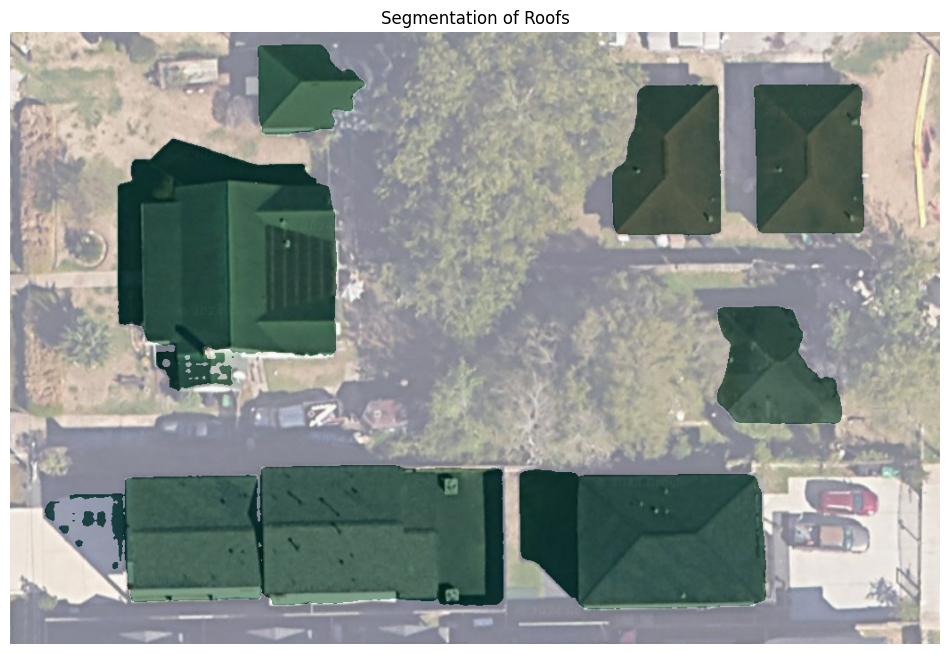

In [100]:
sam.show_anns(
    cmap="Greens",
    add_boxes=False,
    alpha=0.5,
    title="Segmentation of Roofs",
    output="roofs.tif",
)

In [19]:
sam.raster_to_vector("roofs.tif", "roofs.shp")

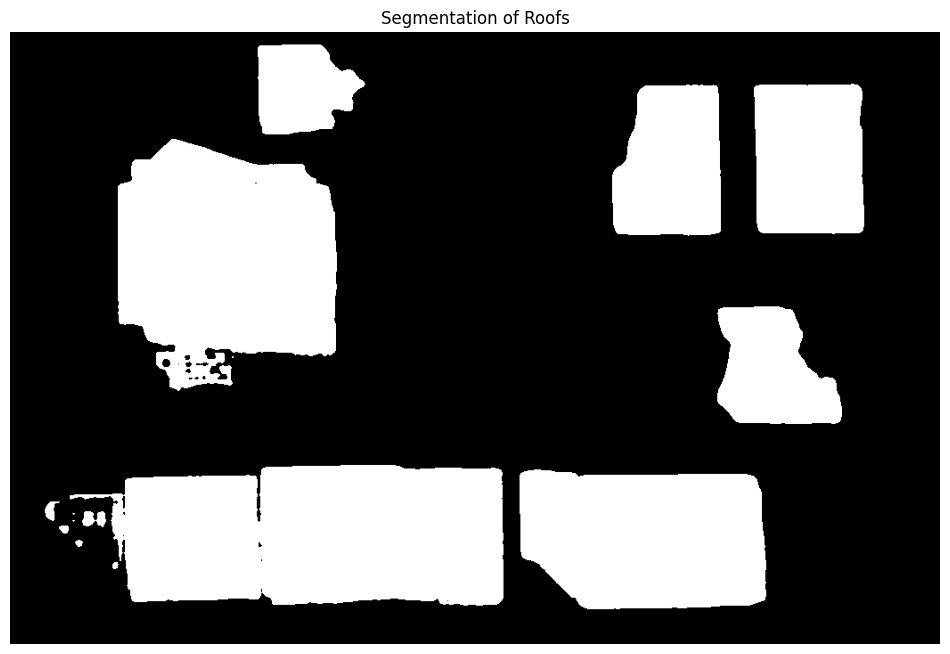

In [101]:
sam.show_anns(
    cmap="Greys_r",
    add_boxes=False,
    alpha=1,
    title="Segmentation of Roofs",
    blend=False,
    output="g-roofs.tif",
)

### Converting pixels to meters.

The pixel to meters width below is used to estimate the area of each roof which is visible to a satellite. 

```
# source: https://samgeo.gishub.org/common/
def resolution_to_zoom_level(resolution):
    """
    Convert map resolution in meters to zoom level for Web Mercator (EPSG:3857) tiles.
    """
    # Web Mercator tile size in meters at zoom level 0
    initial_resolution = 156543.03392804097

    # Calculate the zoom level
    zoom_level = math.log2(initial_resolution / resolution)

    return int(zoom_level)
```

Shapes which are close together are considered to belong to a single property.

In [59]:
def pixels_to_meters(pixels, zoom=21):
    initial_res = 156543.03392804097
    return (initial_res * pixels) / (2 ** zoom)

In [74]:
kernel = np.ones((50, 50), np.uint8)
dilated = cv2.dilate(img, kernel)

contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

roofs = []

for contour in contours:
    rect = cv2.minAreaRect(contour)
    (x, y), (width, height), angle = rect
    width_meters = pixels_to_meters(width)
    height_meters = pixels_to_meters(height)
    roofs.append((round(width_meters, 2), round(height_meters, 2)))
    print(f"Width (pixels): {width:.1f}, Height (pixels): {height:.1f}, Angle: {angle:.1f}")
    print(f"Width (meters): {width_meters:.1f}, Height (meters): {height_meters:.1f}")
    print("==============================================")

Width (pixels): 860.0, Height (pixels): 207.6, Angle: 0.8
Width (meters): 64.2, Height (meters): 15.5
Width (pixels): 188.0, Height (pixels): 180.0, Angle: -0.0
Width (meters): 14.0, Height (meters): 13.4
Width (pixels): 218.3, Height (pixels): 331.2, Angle: 89.7
Width (meters): 16.3, Height (meters): 24.7
Width (pixels): 427.0, Height (pixels): 326.0, Angle: 90.0
Width (meters): 31.9, Height (meters): 24.3


### Fitting shapes into non-uniform bins

Fitting shapes into non-uniform bins involves allocating objects of varying sizes into containers with different capacities. The goal is to optimize space usage while considering practical constraints like bin capacity and shape irregularity.

```
Algorithm 1 Load Balancing Protocol
1: for all balls do
2:   Independently choose a set B of d bins at random
3:   Determine the set Bopt ⊆ B of bins that would have the lowest load after allocating the ball
4:   Determine the maximum capacity cmax of the bins in Bopt
5:   Remove all bins bj with capacity cj < cmax from Bopt
6:   i.u.r. choose a bin from Bopt and allocate the ball to it
7: end for
```

> source: https://www.sciencedirect.com/science/article/pii/S0743731513002190

The algorithm above is applied to this problem to generate rough estimates of the number of solar panels which fit on each _property_ (i.e. properties might have more than one roof).

The solar panels are sized at $1.7m \times 1m$.

In [75]:
print(roofs)

[(64.19, 15.5), (14.03, 13.44), (16.29, 24.73), (31.87, 24.33)]


In [78]:
def get_vertices_from_rectangles(rectangles):
   vertices = []
   current_x = 0
   
   for width, height in rectangles:
       vertices.append([current_x, 0])
       vertices.append([current_x + width, 0])

       vertices.append([current_x + width, height])
       vertices.append([current_x, height])
       
       current_x += width
   
   return np.array(vertices)

def solar_panels_in_irregular_area(container_vertices, rect_width=1, rect_height=1.7):
   points = np.array(container_vertices)

   hull = ConvexHull(points)
   area = hull.area
   rect_area = rect_width * rect_height

   packing_density = 0.85

   edge_factor = 1 - (hull.area / hull.volume) * 0.1
   
   theoretical_count = (area * packing_density * edge_factor) / rect_area
 
   estimated = int(theoretical_count * (1 + np.random.normal(0, 0.08)))
   
   return max(1, estimated)

estimates = []

for rect in roofs:
   vertices = np.array([
       [0, 0],
       [rect[0], 0], 
       [rect[0], rect[1]],
       [0, rect[1]]
   ])
   estimate = solar_panels_in_irregular_area(vertices)
   estimates.append(estimate)

print(estimates)

[78, 26, 43, 56]


### Number of solar panels which can be fitted on the roof of each property

![title](g-roofs_annotated.png)